purpose: translate Rat GWAS into human orthologs (and maybe human to rat once a co-expression network made). After ortholog mapping, define seed gene sets. For ortho mapping- using bestmatch.

# Set-up

In [1]:
import os
import pandas as pd
import statsmodels.stats.multitest
from scipy import stats
import matplotlib.pyplot as plt
import re

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

# define ortholog dictionary

In [3]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']

In [4]:
ortho_best=ortho[ortho['IsBestScore']=='Yes']
ortho_best

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [5]:
ortho_best_both=ortho_best[ortho_best['IsBestRevScore']=='Yes']

lose 1753 genes if filter for best reverse

In [6]:
ortho[ortho['AlgorithmsMatch']>2]

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


lose 1006 if filter for >2 databases rather than best ortholog

# Read in rat genes (MAGMA)

In [7]:
test='gsem'

In [8]:
if ((test=='meta')|(test=='mega')):
    loco_magma=pd.read_csv('magma/loco_meta_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif test=='gsem':
    loco_magma=pd.read_csv('magma/loco_gsem_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)


In [9]:
loco_magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,Vom2r5,1,1151906,1180559,2,1,7722,2.132000,0.016502
1,Vom2r6,1,1204035,1232755,2,1,7722,2.125600,0.016770
2,LOC102547284,1,1735535,1764558,3,1,7722,-0.039391,0.515710
3,Raet1c,1,1781462,1806110,2,1,7722,-0.288910,0.613670
4,LOC120093164,1,1797226,1822755,2,1,7722,-0.288910,0.613670
...,...,...,...,...,...,...,...,...,...
18862,Ascc3,20,53500137,53805446,340,1,7722,-0.627520,0.734840
18863,Sim1,20,53817601,53917219,148,1,7722,-0.569050,0.715340
18864,LOC103694460,20,54404724,54428200,56,1,7722,-0.669640,0.748460
18865,Cd99,20,54408239,54432882,53,1,7722,-0.662330,0.746120


In [14]:
len(set(ortho_best['Gene1Symbol']))-len(set(ortho_best['Gene2Symbol']))

1002

In [15]:
len(set(ortho_best_both['Gene1Symbol']))-len(set(ortho_best_both['Gene2Symbol']))

27

# test cutoffs

## bonferroni

In [16]:
0.05/len(loco_magma)

2.650129856362962e-06

In [25]:
loco_magma[loco_magma['P']<0.05/len(loco_magma)]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
1844,Dmbt1,1,185607469,185706476,157,4,7722,5.8324,2.732100e-09
1846,C1h10orf120,1,185900420,185923478,97,5,7722,4.7754,8.968200e-07
1848,Cuzd1,1,186079422,186140536,224,5,7722,5.1489,1.309800e-07
1849,RGD1559891,1,186098544,186121598,73,4,7722,4.7203,1.177400e-06
1850,Fam24b,1,186102544,186125957,67,4,7722,4.7107,1.234600e-06
1851,Fam24a,1,186109918,186132932,70,4,7722,4.5922,2.193000e-06
1856,Hmx3,1,186303237,186325201,19,2,7722,5.1012,1.687800e-07
1857,Hmx2,1,186309110,186336771,22,3,7722,5.1291,1.456000e-07
1858,Bub3,1,186320358,186350969,34,3,7722,4.7536,9.992100e-07
1859,Gpr26,1,186756001,186815435,136,4,7722,6.3017,1.472000e-10


## FDR

In [26]:
#compare before and after ortholog mapping
loco_magma['FDR_corr']=statsmodels.stats.multitest.fdrcorrection(loco_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

(array([1310., 1346., 1815., 1956., 2068., 2388., 2181., 1896., 1885.,
        2022.]),
 array([2.77722240e-06, 1.00001500e-01, 2.00000222e-01, 2.99998944e-01,
        3.99997666e-01, 4.99996389e-01, 5.99995111e-01, 6.99993833e-01,
        7.99992555e-01, 8.99991278e-01, 9.99990000e-01]),
 <BarContainer object of 10 artists>)

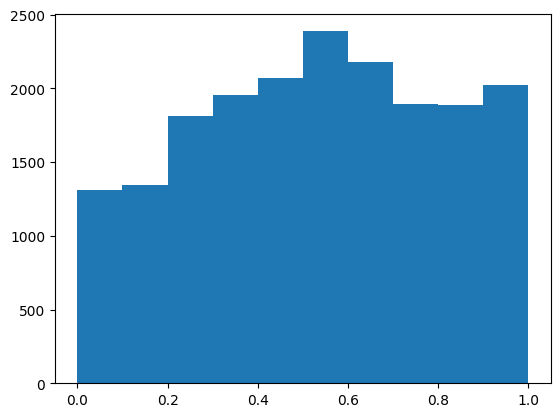

In [27]:
plt.hist(loco_magma['FDR_corr'])

In [28]:
loco_magma[loco_magma['FDR_corr']<0.05]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,FDR_corr
1840,Tacc2,1,185129223,185337881,525,17,7722,3.6039,1.567100e-04,0.015988
1841,Btbd16,1,185324971,185399518,230,10,7722,3.7702,8.156900e-05,0.011659
1842,Plekha1,1,185417982,185489157,123,4,7722,3.1689,7.650600e-04,0.034782
1843,Htra1,1,185487815,185557380,244,7,7722,3.8279,6.461900e-05,0.010694
1844,Dmbt1,1,185607469,185706476,157,4,7722,5.8324,2.732100e-09,0.000017
...,...,...,...,...,...,...,...,...,...,...
17945,LOC686013,19,24136815,24160983,26,2,7722,3.1287,8.780100e-04,0.037734
17946,Samd1,19,24141136,24164475,35,2,7722,3.1385,8.490800e-04,0.036890
17947,Prkaca,19,24145081,24188430,74,2,7722,3.1250,8.889600e-04,0.037946
17948,Asf1b,19,24171024,24205604,37,2,7722,3.0354,1.201300e-03,0.045512


# merge in human orthologs

In [29]:
loco=loco_magma.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='GENE',right_on='Gene1Symbol',how='left').dropna().reset_index().drop(['index','Gene1Symbol'],axis=1)
loco.columns=['GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N', 'ZSTAT', 'P',
       'Q', 'HM_ORTHO']

In [30]:
loco

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,Q,HM_ORTHO
0,Raet1l,1,1969433,1994410,2,1,7722,0.54184,0.29396,0.557457,RAET1E
1,Lrp11,1,2038307,2118115,149,4,7722,0.11032,0.45608,0.682143,LRP11
2,Pcmt1,1,2101756,2170354,149,3,7722,0.20261,0.41972,0.657876,PCMT1
3,Nup43,1,2134427,2167887,70,3,7722,0.14680,0.44165,0.673114,NUP43
4,Lats1,1,2150411,2203640,57,3,7722,0.01522,0.49393,0.706522,LATS1
...,...,...,...,...,...,...,...,...,...,...,...
16447,Hace1,20,49025312,49161103,203,5,7722,-0.73798,0.76974,0.880761,HACE1
16448,Grik2,20,52125325,52843061,1295,2,7722,-1.58440,0.94345,0.966795,GRIK2
16449,Ascc3,20,53500137,53805446,340,1,7722,-0.62752,0.73484,0.862362,ASCC3
16450,Sim1,20,53817601,53917219,148,1,7722,-0.56905,0.71534,0.850001,SIM1


In [31]:
if test=='meta':
    loco.to_csv('magma/seed_genes/loco_win10_annot.tsv',sep='\t', index=False)
elif test=='gsem':
    loco.to_csv('magma/seed_genes/loco_gsem_annot.tsv',sep='\t', index=False)


# externalizing (MAGMA)

In [3]:
set=['munged','orig']
file=set[1]

In [4]:
ext_magma=pd.read_csv('magma/ext_'+file+'.genes.out',delim_whitespace=True,index_col=None,skiprows=0)

In [8]:
gene_loc=pd.read_csv('/tscc/projects/ps-palmer/brittany/magma_v1/NCBI38/NCBI38.gene.loc',sep='\t',header=None)
gene_loc.columns=['ID','CHR','START','STOP','STAND','GENE_NAME']

In [6]:
ext_magma=gene_loc[['ID','GENE_NAME']].merge(ext_magma, left_on='ID',right_on='GENE',how='right').reset_index().drop(['index','GENE'],axis=1)
ext_magma.columns=['ID', 'GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N','ZSTAT', 'P']

In [9]:
ext_magma['Q']=statsmodels.stats.multitest.fdrcorrection(ext_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [10]:
ext_magma.to_csv('magma/seed_genes/ext_'+file+'_annot.tsv',sep='\t',index=False)

# externalizing (FUSION)

In [40]:
ext_fus=pd.read_csv('ext_FUSION/FUSION_concat/ext2019_GTEx.Brain_Nucleus_accumbens_basal_ganglia.dat',delim_whitespace=True)

In [44]:
ext_fus=ext_fus.dropna(subset=['ID','TWAS.P'],axis=0).reset_index()

In [50]:
ext_fus=ext_fus.drop('index',axis=1)

In [46]:
ext_fus['Q']=statsmodels.stats.multitest.fdrcorrection(ext_fus['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [53]:
ext_fus.to_csv('ext_FUSION/ext_fusion_NACC_seed.tsv',sep='\t',index=False)

# locomotor mega (FUSION)

In [6]:
def extract_IDs(annot, type=None):
    if (type=='gene'):
        #print('returning ENSRNOG')
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOG')]
        if len(ls)>0:
            return(ls[0])
    elif (type=='transcript'):
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOT')]
        if len(ls)>0:
            return(ls[0])
    else:
        return [x for x in re.split('[:.]', annot) if x.startswith('ENSR')]

In [7]:
loco_dir='loco_twas_dan/'

In [8]:
fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')

/tmp/ipykernel_3514057/1034971248.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')


In [9]:
#downloaded from ensembl BioMart on 9 July 2024 for mRatBN7.2
gene_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.gene_map.gtf.gz',compression='gzip',sep='\t')
transcript_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.transcript_map.gtf.gz',compression='gzip',sep='\t')

In [10]:
#locomotor activity TWAS calculated by FUSION by Dan Munroe
tbl=pd.read_csv('loco_twas_dan/regressedlr_combined_locomotor.dat',sep='\t')
tbl['TISSUE']=[s.split('.')[1] for s in tbl.PANEL]
tbl['TYPE_MOD']=[s.split('.')[2] for s in tbl.PANEL]

In [11]:
tbl['ID_ls']=tbl['ID'].apply(extract_IDs)
tbl['gene_id']=tbl['ID'].apply(extract_IDs,type='gene')
tbl['tran_id']=tbl['ID'].apply(extract_IDs,type='transcript')

In [12]:
#add in gene name
t=tbl.merge(gene_tbl[['Gene stable ID','Gene name']], left_on='gene_id',right_on='Gene stable ID',how='left').drop('Gene stable ID', axis=1)
t=t.merge(transcript_tbl[['Transcript stable ID','Transcript name']], left_on='tran_id',right_on='Transcript stable ID',how='left').drop('Transcript stable ID', axis=1)
#t_exp=t[t.TYPE_MOD=='expression']

In [13]:
t=t[(t['TYPE_MOD']=='expression')&(t['TISSUE']=='NAcc2')]

In [14]:
0.05/len(t)

9.338812103100487e-06

In [93]:
t=t.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='Gene name',right_on='Gene1Symbol',how='left')

In [97]:
t=t.dropna(subset=['Gene2Symbol','Gene1Symbol','TWAS.P'],axis=0).drop(['Gene1Symbol'],axis=1)

In [107]:
t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

/tmp/ipykernel_3504319/663195165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]


In [109]:
t=t.rename(columns = {'Gene2Symbol':'human_ortholog'})

In [110]:
t.to_csv(loco_dir+'/loco_fusion_NACC_seed.tsv',sep='\t',index=False)